<a href="https://colab.research.google.com/github/fatday/STATS-305B-HW4-Group/blob/main/Part2_Empty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 1 Code Set up

In [ ]:
# torch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
from tqdm import tqdm
import requests
import os

torch.manual_seed(305)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

We set default values for some global hyperparameters, but feel free to change these during development as needed.

In [ ]:
# Global hyperparameters
SMALL_ITERS = 1000
LARGE_ITERS = 2000
EVAL_ITERS = 100
CONTEXT_WINDOW_SIZE = 256

## Part 0: Preprocessing

### 0.1: Loading and preprocessing the dataset


The first step is to download the dataset. We will be using a dataset from Andrej Karpathy consisting of a subset of works from Shakespeare.

The dominant mode for preprocessing textual data is to tokenize it; that is, to split the dataset into a finite vocabulary of tokens. Then, we can set up a dictionaries mapping from counting numbers (representing tokens) to tokens and vice versa. Tokens can be characters, or words, or subwords; in fact, the "best" way to tokenize text is an active area of research.

To keep things simple, we'll tokenize the text on a per-character level.

In [ ]:
# download the tiny shakespeare dataset
input_file_path = 'input.txt'

if not os.path.exists(input_file_path):
    data_url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
    with open(input_file_path, 'w') as f:
        f.write(requests.get(data_url).text)

with open(input_file_path, 'r') as f:
    data = f.read()
print(f"length of dataset in characters: {len(data):,}")

length of dataset in characters: 1,115,394


In [ ]:
# get all the unique characters that occur in this text
chars = sorted(list(set(data)))
vocab_size = len(chars)
print("all the unique characters:", ''.join(chars))
print(f"vocab size: {vocab_size:,}")

all the unique characters: 
 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
vocab size: 65


In [ ]:
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }

def encode(s):
    return [stoi[c] for c in s] # encoder: take a string, output a list of integers
def decode(l):
    return ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# create the train and test splits
n = len(data)
train_chars = data[:int(n*0.9)]
val_chars = data[int(n*0.9):]

# encode both to integers
train_data = encode(train_chars)
val_data = encode(val_chars)

# cast as torch tensors
train_data = torch.tensor(train_data)
val_data = torch.tensor(val_data)

print(f"train has {len(train_data):,} tokens")
print(f"val has {len(val_data):,} tokens")

train has 1,003,854 tokens
val has 111,540 tokens


We also write helper functions to get batches of data and to evaluate the loss of various models on them.

In [ ]:
# function for getting batches of data
def get_batch(split, context_window_size, device, batch_size=32):
    """
    generate a small batch of data of inputs x and targets y

    Args:
        split: 'train' or 'val'
        device: 'cpu' or 'cuda' (should be 'cuda' if available)
    """
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - context_window_size, (batch_size,))
    x = torch.stack([data[i:i+context_window_size] for i in ix])
    y = torch.stack([data[i+1:i+context_window_size+1] for i in ix])
    x = x.to(device)
    y = y.to(device)
    return x, y

# helper function for tracking loss during training
# given to you
@torch.no_grad()
def estimate_loss(model, eval_iters, context_window_size, device):
    """
    Args:
      model: model being evaluated
      eval_iters: number of batches to average over
      context_window_size: size of the context window
      device: 'cpu' or 'cuda' (should be 'cuda' if available)
    """
    out = {}
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split, context_window_size, device)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    return out

In [ ]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size, context_window_size, embed_size=384):
        """
        Args:
          head_size: int, size of the head embedding dimension (K)
          context_window_size: int, number of tokens considered in the past for attention (T)
          embed_size: int, size of the token embedding dimension (D)
        """
        super().__init__()
        self.head_size = head_size
        self.key = nn.Linear(embed_size, head_size, bias=False)
        self.query = nn.Linear(embed_size, head_size, bias=False)
        self.value = nn.Linear(embed_size, embed_size, bias=False)

        # not a param of the model, so registered as a buffer
        self.register_buffer('tril', torch.tril(
            torch.ones(context_window_size, context_window_size)))

    def forward(self, x):
        """
        Args:
          x: (B,T,D) tensor of token embeddings

        Returns:
          (B,T,D) tensor of attention-weighted token embeddings
        """
        # TODO: your code here
        B,T,D = x.shape
        k = self.key(x)
        q = self.query(x)
        v = self.value(x)
        wei = q @ k.transpose(-2,-1) * self.head_size**-0.5
        #tril = torch.tril(torch.ones(T, T, device=x.device))
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)  ## wei.shape:
        out = wei @ v
        return out

In [ ]:
class SingleHeadedAttentionLM(nn.Module):

    def __init__(self, vocab_size, context_window_size, head_size, embed_size=384):
      """
      Args:
        vocab_size: int, size of the vocabulary (V)
        context_window_size: int, number of tokens considered in the past for attention (T)
        head_size: int, size of the head embedding dimension (K)
        embed_size: int, size of the token embedding dimension (D)
      """
      super().__init__()
      self.token_embedding_table = nn.Embedding(vocab_size, embed_size)
      self.position_embedding_table = nn.Embedding(context_window_size, embed_size)
      self.context_window_size = context_window_size

      # TODO: your code below
      self.atten_head = Head(head_size, context_window_size)
      self.lm_head = nn.Linear(embed_size, vocab_size)
      self.context_window_size = context_window_size

    def forward(self, token_ids, targets=None):
        """
        Args:
          token_ids: (B, T) token ids that make up the context (batch has size B, each entry
                     in the batch has length T)
          targets: (B, T) token ids corresponding to the target of each context in token_ids

        Returns:
          logits: (B, T, V) logits[b,t] gives the length V vector of logits for the next token
                   prediction in string b up to t tokens
          loss: scalar, negative log likelihood of target given context
        """
        B, T = token_ids.shape # (batch size, length)
        tok_emb = self.token_embedding_table(token_ids) # (B,T,D)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,D)
        x = tok_emb + pos_emb # (B,T,D)
        x = self.atten_head(x) # (B,T,D)
        logits = self.lm_head(x) # (B,T,V)

        # TODO: your code here
        B, T, V = logits.shape
        logits = logits.view(B*T, V)
        if targets is None:
            loss = None
        else:
            targets = targets.view(B*T)
            loss = -torch.mean(torch.log(F.softmax(logits, dim=1)[torch.arange(B*T), targets]))
        return logits, loss

    @torch.no_grad()
    def generate(self, token_ids, max_new_tokens):
        """
        Args:
          token_ids: (B, T) tensor of token ids to provide as context
          max_new_tokens: int, maximum number of new tokens to generate

        Returns:
          (B, T+max_new_tokens) tensor of context with new tokens appended
        """
        #TODO
        # your code below
        B, T = token_ids.shape
        new_token_sequences = torch.zeros((B, T+max_new_tokens), dtype=torch.long, device=token_ids.device)
        new_token_sequences[:, :T] = token_ids
        for t in range(max_new_tokens):
          input_tokens = new_token_sequences[:, max(0, T + t - self.context_window_size): T + t]
          logits, loss = self(input_tokens)
          logits = logits.view(B, min(T + t, self.context_window_size), -1)
          logits = logits[:, -1, :]
          probs = F.softmax(logits, dim=-1)
          new_token = torch.multinomial(probs, num_samples=1)
          new_token_sequences[:, T + t] = new_token.squeeze(-1)
        return new_token_sequences

In [ ]:

class MultiHeadAttention(nn.Module):
    def __init__(self, context_window_size, num_heads, embed_size):
        super().__init__()
        self.num_heads = num_heads
        self.head_size = embed_size // num_heads  # 确保总维度匹配

        self.heads = nn.ModuleList(
            [Head(self.head_size, context_window_size, embed_size) for _ in range(num_heads)]
        )
        self.proj = nn.Linear(embed_size * num_heads, embed_size)  # 确保总维度匹配
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)  # 拼接 heads

        out = self.dropout(self.proj(out))  # 投影回 embed_size
        return out


In [ ]:
class MultiHeadedAttentionLM(nn.Module):

    def __init__(self, vocab_size, context_window_size, embed_size=384, num_heads=6):
      super().__init__()
      self.head_size = embed_size // num_heads
      self.context_window_size = context_window_size
      # TODO: your code below
      self.token_embedding_table = nn.Embedding(vocab_size, embed_size)
      self.position_embedding_table = nn.Embedding(context_window_size, embed_size)
      self.atten_heads = MultiHeadAttention(context_window_size, num_heads, embed_size)
      self.lm_head = nn.Linear(embed_size, vocab_size)


    def forward(self, token_ids, targets=None):
        """
        Args:
          token_ids: (B, T) token ids that make up the context (batch has size B, each entry in the
                     batch has length T)
          targets: (B, T) token ids corresponding to the target of each context in token_ids

        Returns:
          logits: (B, T, V), logits[b,t] gives the length V vector of logits for the next token
                  prediction in string b up to t tokens
          loss: scalar, negative log likelihood of target given context
        """
        # TODO: your code below
        B, T = token_ids.shape
        tok_emb = self.token_embedding_table(token_ids)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device))
        x = tok_emb + pos_emb
        x = self.atten_heads(x)
        logits = self.lm_head(x)
        if targets is None:
            loss = None
        else:
            logits = logits.view(B*T, -1)
            targets = targets.view(B*T)
            loss = -torch.mean(torch.log(F.softmax(logits, dim=1)[torch.arange(B*T), targets]))

        return logits, loss

    @torch.no_grad()
    def generate(self, token_ids, max_new_tokens):
        """
        Args:
          token_ids: (B, T) tensor of token ids to provide as context
          max_new_tokens: int, maximum number of new tokens to generate

        Returns:
          (B, T+max_new_tokens) tensor of context with new tokens appended
        """
        # TODO: your code below
        B, T = token_ids.shape
        new_token_sequences = torch.zeros((B, T+max_new_tokens), dtype=torch.long, device=token_ids.device)
        new_token_sequences[:, :T] = token_ids
        for t in range(max_new_tokens):
          input_tokens = new_token_sequences[:, max(0, T + t - self.context_window_size): T + t]
          logits, loss = self(input_tokens)
          logits = logits.view(B,min(T + t, self.context_window_size), -1)
          logits = logits[:, -1, :]
          probs = F.softmax(logits, dim=-1)
          new_token = torch.multinomial(probs, num_samples=1)
          new_token_sequences[:, T + t] = new_token.squeeze(-1)
        return new_token_sequences

In [ ]:
# run this cell to initialize this deep learning module that you should use in the code your write later
# you don't need to edit this layer
class FeedForward(nn.Module):
    """ a simple linear layer followed by a non-linearity
        Given to you, you don't need to write any code here!
    """

    def __init__(self, embed_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(embed_size, 4 * embed_size),
            nn.ReLU(),
            nn.Linear(4 * embed_size, embed_size),
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
class TransformerBlock(nn.Module):
    """ Transformer block: communication across sequence length, followed by communication across embedding space
        Uses multi-headed attention
    """

    def __init__(self, vocab_size, context_window_size, embed_size=384, num_heads=6):
        super().__init__()
        self.ln1 = nn.LayerNorm(embed_size)
        self.ln2 = nn.LayerNorm(embed_size)

        # TODO: your code below
        self.feed_forward = FeedForward(embed_size)
        self.atten_heads = MultiHeadAttention(context_window_size, num_heads, embed_size)

    def forward(self, x):
        x = x + self.atten_heads(self.ln1(x)) # communication over sequence length
        x = x + self.feed_forward(self.ln2(x)) # communication across embedding space
        return x

In [ ]:
class TransformerLM(nn.Module):

    def __init__(self, vocab_size, context_window_size, embed_size=384, num_heads=6, n_layers=6):
        """
          Args:
              vocab_size: int, number of tokens in the vocabulary (V)
              context_window_size: int, size of the context window (T)
              embed_size: int, embedding size (D)
              num_heads: int, number of heads (H)
              n_layers: int, number of layers (M)
        """
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, embed_size)
        self.position_embedding_table = nn.Embedding(context_window_size, embed_size)
        self.blocks = nn.Sequential(*[
            TransformerBlock(vocab_size,
                             context_window_size,
                             embed_size=embed_size,
                             num_heads=num_heads)
            for _ in range(n_layers)])

        # final layer norm
        self.ln_f = nn.LayerNorm(embed_size)
        self.lm_head = nn.Linear(embed_size, vocab_size)
        self.context_window_size = context_window_size

        # good initialization
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, token_ids, targets=None):
        """
        Agrgs:
            token_ids: tensor of integers, provides the contet, shape (B, T)
            targets: tensor of integers, provides the tokens we are preidcitng, shape (B, T)
        """
        B, T = token_ids.shape

        # token_ids and targets are both (B, T) tensor of integers
        tok_emb = self.token_embedding_table(token_ids) # (B, T, D)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T, D)
        x = tok_emb + pos_emb # (B, T, D)

        # TODO: your code below
        logits = ...
        loss = ...

        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)

        B, T, V = logits.shape
        logits = logits.view(B*T, V)

        if targets is None:
            loss = None
        else:
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    @torch.no_grad()
    def generate(self, token_ids, max_new_tokens):
        """
        Args:
            token_ids: tensor of integers forming the context, shape (B, T)
            max_new_tokens: int, max number of tokens to generate
        """
        # TOOD, your code below
        B, T = token_ids.shape
        context_length = self.position_embedding_table.num_embeddings
        new_token_sequences = torch.zeros((B, T+max_new_tokens), dtype=torch.long, device=token_ids.device)
        new_token_sequences[:, :T] = token_ids
        for t in range(max_new_tokens):
            input_tokens = new_token_sequences[:, max(0,T + t - context_length):T + t]
            logits, loss = self(input_tokens)
            logits = logits.view(B,min(T + t, self.context_window_size), -1)
            logits = logits[:, -1, :] # (B, V)
            probs = F.softmax(logits, dim=-1) # (B, V)
            new_token = torch.multinomial(probs, num_samples=1) # (B, 1)
            new_token_sequences[:, T + t] = new_token.squeeze(-1) # (B, T+1)
        return new_token_sequences

In [ ]:
trans = TransformerLM(vocab_size, CONTEXT_WINDOW_SIZE)
tlm = trans.to(device)
learning_rate = 1e-4
# TODO, your code below

optimizer = torch.optim.AdamW(trans.parameters(), lr=learning_rate)

eval_interval = 200

loss_list = []

for it in tqdm(range(LARGE_ITERS)):

    # every once in a while evaluate the loss on train and val sets
    if it % eval_interval == 0 or it == LARGE_ITERS - 1:
      print(f"iteration {it}")
      losses = estimate_loss(tlm, EVAL_ITERS, CONTEXT_WINDOW_SIZE, device)
      print(f"step {it}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train', CONTEXT_WINDOW_SIZE, device)

    # evaluate the loss
    logits, loss = tlm(xb, yb)
    loss_list.append(loss.detach().item())
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

  0%|          | 0/2000 [00:00<?, ?it/s]

iteration 0


  0%|          | 1/2000 [00:06<3:34:34,  6.44s/it]

step 0: train loss 4.2866, val loss 4.2850


 10%|▉         | 199/2000 [00:25<02:50, 10.54it/s]

iteration 200


 10%|█         | 201/2000 [00:31<31:15,  1.04s/it]

step 200: train loss 2.4913, val loss 2.5005


 20%|█▉        | 399/2000 [00:50<02:31, 10.56it/s]

iteration 400


 20%|██        | 401/2000 [00:56<27:43,  1.04s/it]

step 400: train loss 2.3444, val loss 2.3695


 30%|██▉       | 599/2000 [01:15<02:12, 10.54it/s]

iteration 600


 30%|███       | 601/2000 [01:22<24:15,  1.04s/it]

step 600: train loss 2.1089, val loss 2.1561


 40%|███▉      | 799/2000 [01:40<01:53, 10.55it/s]

iteration 800


 40%|████      | 801/2000 [01:47<20:46,  1.04s/it]

step 800: train loss 1.9199, val loss 2.0153


 50%|████▉     | 999/2000 [02:06<01:35, 10.54it/s]

iteration 1000


 50%|█████     | 1001/2000 [02:12<17:19,  1.04s/it]

step 1000: train loss 1.7761, val loss 1.9142


 60%|█████▉    | 1199/2000 [02:31<01:15, 10.54it/s]

iteration 1200


 60%|██████    | 1201/2000 [02:37<13:51,  1.04s/it]

step 1200: train loss 1.6817, val loss 1.8326


 70%|██████▉   | 1399/2000 [02:56<00:56, 10.59it/s]

iteration 1400


 70%|███████   | 1401/2000 [03:03<10:23,  1.04s/it]

step 1400: train loss 1.6039, val loss 1.7801


 80%|███████▉  | 1599/2000 [03:22<00:38, 10.53it/s]

iteration 1600


 80%|████████  | 1601/2000 [03:28<06:55,  1.04s/it]

step 1600: train loss 1.5552, val loss 1.7327


 90%|████████▉ | 1799/2000 [03:47<00:19, 10.55it/s]

iteration 1800


 90%|█████████ | 1801/2000 [03:53<03:27,  1.04s/it]

step 1800: train loss 1.5017, val loss 1.7037


100%|█████████▉| 1999/2000 [04:12<00:00, 10.54it/s]

iteration 1999


100%|██████████| 2000/2000 [04:18<00:00,  7.72it/s]

step 1999: train loss 1.4703, val loss 1.6787


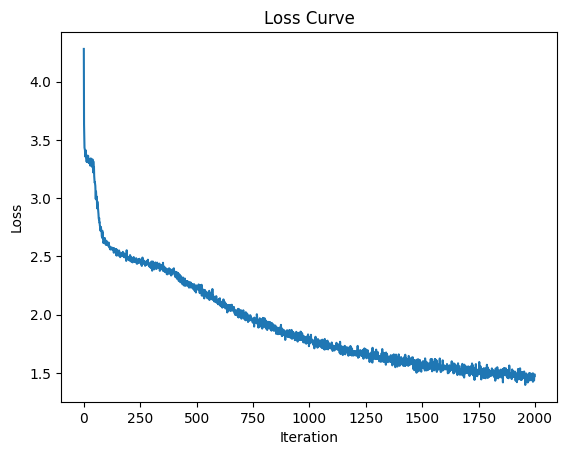

In [ ]:
## plot the loss_curve
plt.plot(loss_list)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.show()

#### Question 1.4.3: Generating text!

Now with our trained model, we can generate some text that is somewhat like the style of Shakespeare! Below we will do both unconditional and conditional generation.

In [ ]:
# unconditional generation from the model
start_context = torch.zeros((1, 1), dtype=torch.long, device=device)
uncond_gen = (tlm.generate(start_context, max_new_tokens=CONTEXT_WINDOW_SIZE)[0].tolist())
print(decode(uncond_gen))


Noriser:
I'll not nime semmbatrous hath a marry.

YORK:
How nor, before hertefore how them to-mar3 morraw,
Go talk three, 'etime king; wherein for the love thee
More Henry and for much for here er swavey ar;
And him wall forcUp me and their was they daught


In [ ]:
# conditional generation from the model

context1 = """ROMEO:
He jests at scars that never felt a wound.
But, soft! what light through yonder window breaks?
It is the east, and Juliet is the sun.
Arise, fair sun, and kill the envious moon,
Who is already sick and pale with grief,
That thou her maid art far more fair than she:
Be not her maid, """

context1_tokens = torch.tensor(encode(context1), device=device).reshape(1, -1)

In [ ]:
cond_gen = (tlm.generate(context1_tokens, max_new_tokens=CONTEXT_WINDOW_SIZE)[0].tolist())
print(decode(cond_gen))

ROMEO:
He jests at scars that never felt a wound.
But, soft! what light through yonder window breaks?
It is the east, and Juliet is the sun.
Arise, fair sun, and kill the envious moon,
Who is already sick and pale with grief,
That thou her maid art far more fair than she:
Be not her maid, and the each wret of die ill serving un,
Buoh his soverer shall the with not these ustood,
To his grace us pousal comfort usuJuesues,
But mode.

ANTIUS:
Is ever were word so chiecave of a doom to the sitter,
Be a reames and look of all meance.
Think you wi


TODO: Choose your own context from Shakespeare, and perform conditional generation from that text. Does this look reasonable to you? Why or why not?

In [ ]:
# TODO: your code here
my_text_con = """First Citizen:
Care for us! True, indeed! They ne'er cared for us
yet: suffer us to famish, and their store-houses
crammed with grain; make edicts for usury, to
support usurers; repeal daily any wholesome act
established against the rich, and provide more
piercing statutes daily, to chain up and restrain
the poor. If the wars eat us not up, they will; and
there's all the love they bear us.

MENENIUS: Either you must
"""

my_text_target = """Confess yourselves wondrous malicious,
Or be accused of folly. I shall tell you
A pretty tale: it may be you have heard it;
But, since it serves my purpose, I will venture
To stale 't a little more."""

In [ ]:
cond_text_token = encode(my_text_con)
target_text_token = encode(my_text_target)

# transfer back to text
target_text_token_size = len(target_text_token)
cond_text_token_size = len(cond_text_token)

# transfer to torch
cond_text_tokens = torch.tensor(cond_text_token, device=device).reshape(1, -1)

# My Input Text:

In [ ]:
print(my_text_con)

First Citizen:
Care for us! True, indeed! They ne'er cared for us
yet: suffer us to famish, and their store-houses
crammed with grain; make edicts for usury, to
support usurers; repeal daily any wholesome act
established against the rich, and provide more
piercing statutes daily, to chain up and restrain
the poor. If the wars eat us not up, they will; and
there's all the love they bear us.

MENENIUS: Either you must 



# Target Text

In [ ]:
print(my_text_target)

Confess yourselves wondrous malicious,
Or be accused of folly. I shall tell you
A pretty tale: it may be you have heard it;
But, since it serves my purpose, I will venture
To stale 't a little more.


# Text Generated for Target

In [ ]:
my_tar_gen = (tlm.generate(cond_text_tokens, max_new_tokens=target_text_token_size)[0].tolist())
my_target_gen_text = decode(my_tar_gen)[cond_text_token_size:]
print(my_target_gen_text)

she creates of the holy subselTt you har:
brow tidle I say you part.  Cammild, prit, not me if
the grave behave again as I have: there you dut ruth,
and for citie know of young! as if your father,
M


## Part 2: Mini-Project

Quick recap: So far we have

1. Preprocessed the Shakespeare dataset by encoding individual characters into integer tokens.
2. Implemented single headed attention and then further generalized to multiheaded attention. We further combined multiheaded attention with deep learning to create the transformer architecture.
3. Trained our transformer and generated output that looks to be in the style of Shakespeare.

Up to this point, the performance of our simple language model has clearly made a lot of progress. We can see that our model has learned to generate text that is close to the style of Shakespeare, although there are still many quirks and room for improvement.

### Project Outline

Find some area of possible improvement.
We interpret "improvement" quite loosely, but please state precisely why your proposed innovation might improve the model, and provide evidence that it does (or does not!) improve.
For your idea, **formulate a hypothesis** for why this change should result in a better model. **Implement your changes** and **report any findings**.

_Notes_: As this assignment is being treated as a project, you should expect training to take longer than previous assignments. However, please use your judgement to decide what is reasonable. We will not expect you to run training procedures that take more than 2 hours on the free Google Colab computing resources and we certainly do not expect you to acquire additional compute. The proposed improvements should not solely rely on increased computing demands.

_Hints_: There are many aspects to assessing a model. For example, not only is quality of generated text important, it is also of interest to reduce costs associated with training.

### Deliverables

In addition to a pdf of your python notebook, the submission for this project will be a written report no more than 4 pages in length using the [NeurIPS LaTex template](https://neurips.cc/Conferences/2023/PaperInformation/StyleFiles). Your report should include detailed analysis of the hypotheses you chose to test along with any conclusions.

The page limit for the report does not include bibliography or appendices. Make sure to keep the "ready for submission" option to help us grade anonymously. Your writeup should also contain a link to any code used to generate the project so that we can reference it while grading (Google Drive folder with colab notebooks or Github repo are both fine). You should have at least one plot in your main text (which is capped at 4 pages).

## Submission Instructions

You will generate two PDFs: one from Part 1, which involves completing this Colab to create a transformer baseline; and one from the mini-project in Part 2, which will be your write-up of no longer than 4 pages. Be sure to include a link to your code for Part 2 somewhere in your writeup.

**Combine the two PDFs into a single PDF and submit on gradescope. Tag your PDF correctly.**

If you work in a group of two, submit one assignment on gradescope and tag your group members. If you complete the assignment individually, submit as usual.